In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import math
import numpy as np
from scipy.stats import linregress
from scipy import stats
import datetime   
from pandas import Series
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import mean_squared_error
from scipy.io import wavfile
from itertools import compress

In [2]:
mypath='C:/Users/sara/Documents/5anno/TESI/tracciati/ConversioneExcel/A E12.06.18'    
df_spo2 = pd.read_csv( mypath+'/SpO2_PDS.csv', names=['time', 'spO2'],header=0)
df_activity = pd.read_csv( mypath+'/Activity_PDS.csv', names=['time', 'activity'],header=0)
spo2_array=df_spo2['spO2']
time_array=df_spo2['time']
activity_array=df_activity['activity']
time_activity_array=df_activity['time']


In [3]:
# lettura del file .csv con i dati delle desat
mypath2='C:/Users/sara/Documents/5anno/TESI/tracciati/Desaturation'    
desatPSD = pd.read_csv( mypath2+'/163Des.csv', names=['Inizio', 'Durata','startSpO2','stopSpO2'],header=0)


In [4]:
ts_activity=10
ts_spO2=3

In [5]:
def remove_days(time):
    if(time>=86400):
        time=time-86400
    return time

<Figure size 432x288 with 0 Axes>

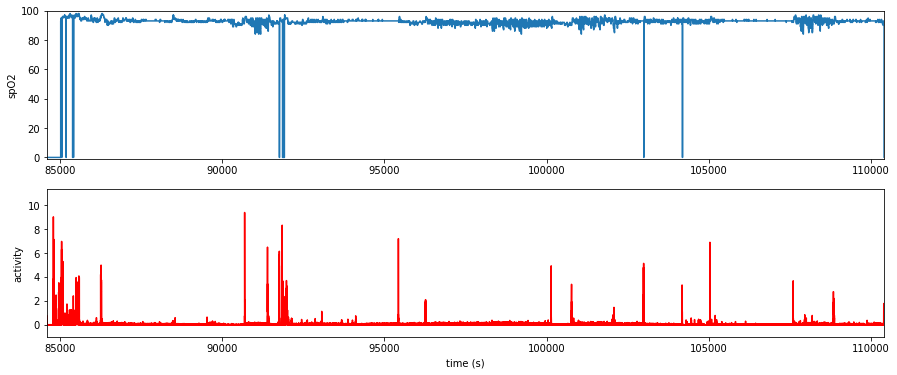

In [6]:
plt.figure()
plt.figure(figsize=(15,6))
plt.title('Plot spO2')
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
#plt.subplot(2, 1, 1)
plt.xlabel('time (s)')
ax1.set_ylabel('spO2')
ax1.axis([time_array[0],time_array[len(time_array)-1],-1,100])
ax1.step(time_array,spo2_array)
ax2.set_ylabel('activity')
ax2.axis([time_array[0],time_array[len(time_array)-1],-1,max(activity_array)+2])
ax2.step(time_activity_array,activity_array,c='r')

# Preprocessing spO2

### Determino gli artifact (valori in cui spO2 è a zero)

##### L'artifact nel sw, parte da valore in cui spO2 è pari a zero e si estende per 6 campioni dopo che spO2 ha ripreso ad essere misurato. => 6 campioni = 2 secondi con un campionamento a 3 Hz

In [10]:
str(datetime.timedelta(seconds=time_array[len(time_array)-1]))

#Creo una lista contenente se all'indice i è presente un artifact
artifact=[]
for i in range(0,len(spo2_array)):
    if(spo2_array[i]==0):
        artifact.append(True)
    else:
        artifact.append(False)

        
        #Estendo l'artifact
i=0
while (i<len(artifact)-1):
    k=0
    if(artifact[i]==True and artifact[i+1]==False):
        if(i<len(artifact)-30):
            while(k<31):
                artifact[i+k]=True
                k=k+1
            i=i+32
        else:
            i=i+1   
    else:i=i+1

#time_artifact=time_array.where(artifact)
# Elimino i valori pari a Zero
index=df_spo2[df_spo2.spO2 == 0].index
df_spo2=df_spo2.drop(df_spo2.index[index])  

#df_spo2['spO2']=spo2_array.where(~(np.array(artifact)))
df_outlier=pd.DataFrame()
df_outlier['time']=np.array(df_spo2['time'])
df_outlier['spO2']=np.array(df_spo2['spO2'])


Text(0.5,0,'time(s)')

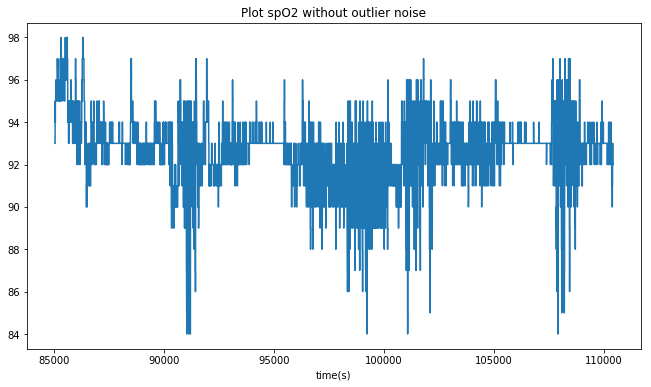

In [54]:
plt.figure(figsize=(11,6))
plt.title('Plot spO2 without outlier noise')
time_array=df_outlier['time']
spo2_array=df_outlier['spO2']
plt.step(time_array,spo2_array,zorder=1)
plt.xlabel('time(s)')


In [65]:
under_90=0
under_80=0
under_70=0
for i in range(0,len(spo2_array)):
    if(spo2_array[i]<90):
        under_90+=1
    '''if(spo2_array[i]<80):
        under_80+=1
    if(spo2_array[i]<70):
        under_70+=1'''
under_90=under_90/ts_spO2/60
under_80=under_80/ts_spO2/60
under_70=under_70/ts_spO2/60
print("belov 90 ",under_90)

belov 90  16.444444444444443


In [64]:
986.6666666666666/60

16.444444444444443

In [62]:
a

75086

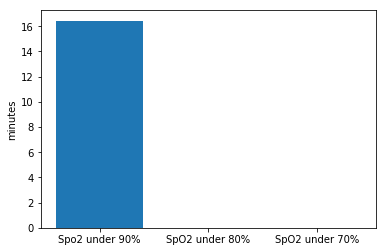

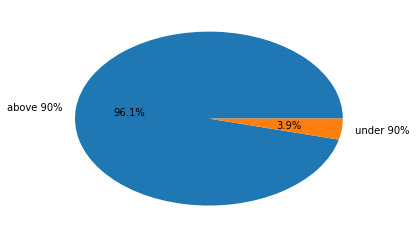

In [73]:
plt.bar(np.arange(3),[under_90,under_80,under_70])
plt.xticks(np.arange(3), ['Spo2 under 90%','SpO2 under 80%','SpO2 under 70%']);
plt.ylabel('minutes')
plt.show()
labels='above 90%','under 90%'
above90=len(spo2_array)/3/60-under_90-under_80-under_70
plt.pie([above90,under_90],labels=labels, autopct='%1.1f%%')
plt.show()

In [37]:
df_under

,90,80,70


In [43]:
spo2_array_adj=[]
for i in range(0,len(spo2_array)):
    spo2_array_adj.append(spo2_array[i])

### Elimino rumori del tipo _-_-_ facendoli diventare ---

In [44]:
index_in=0
index_fin=0
tin=0
tfin=0
CASE=0
for i in range(1,len(spo2_array_adj)):
    if(CASE==0 and spo2_array_adj[i]>spo2_array_adj[i-1]): #inizio gradino
        spO2Base=spo2_array_adj[i]
        CASE=1
    elif(CASE==1 and spo2_array_adj[i]<spo2_array_adj[i-1]): #fine gradino
        index_in=i
        tin=time_array[i]
      #  print('start : ',tin, index_in)
        spO2Base2=spo2_array_adj[i-1]         
        CASE=2
    elif(CASE==1 and spo2_array_adj[i]>spo2_array_adj[i-1]): #errore
        spO2Base=spo2_array_adj[i]
        CASE=1
    elif(CASE==2 and spo2_array_adj[i]>spo2_array_adj[i-1]): #nizio nuovo gradino
        index_fin=i
        tfin=time_array[i]
        #print('stop : ',tfin)
        CASE=3
    elif(CASE==2 and spo2_array_adj[i]<spo2_array_adj[i-1]): #errore
        CASE=0
        #print('errr  ')
    elif(CASE==3 and spo2_array_adj[i]<spo2_array_adj[i-1]): #fine nuovo gradino
        spO2Base3=spo2_array_adj[i-1]
        if(spO2Base==spO2Base2 and spO2Base2==spO2Base3 and tfin-tin<4):
            for k in range(index_in,index_fin):
                spo2_array_adj[k]=spO2Base
        CASE=0    
    elif(CASE==3 and spo2_array_adj[i]>spo2_array_adj[i-1]): #errore
        spO2Base=spo2_array_adj[i]
        CASE=1
            
        

### Elimino gradini di spO2 che ritornano subito al valore iniziale verso l'alto 

In [45]:
inizioGradino=0
fineGradino=0
CASE=0
counter=0
spO2Base=0
diff=0
for i in range(1,len(spo2_array_adj)):
    if(spo2_array_adj[i]>spo2_array_adj[i-1]):    
        diff=spo2_array_adj[i]-spo2_array_adj[i-1]
        spO2Base=spo2_array_adj[i-1]
        inizioGradino=i
        counter=1
        CASE=1
    elif(CASE==1 and spo2_array_adj[i]==spo2_array_adj[i-1]):
        counter+=1
    elif(CASE==1 and spo2_array_adj[i]<spo2_array_adj[i-1]):
        if(spo2_array_adj[i]==spO2Base):
            fineGradino=i
            CASE=2
    if(CASE==2 and time_array[fineGradino]-time_array[inizioGradino]<4):
        for k in range(inizioGradino,fineGradino):
            spo2_array_adj[k]=spO2Base  

### Detect activity 

In [46]:
spo2_array=spo2_array_adj

In [47]:
serie=pd.DataFrame()
serie['activity']=activity_array
serie.index=df_activity['time']
ts = df_activity['activity'] 

media:  0.04216227188301306
std:  0.15763780659781457


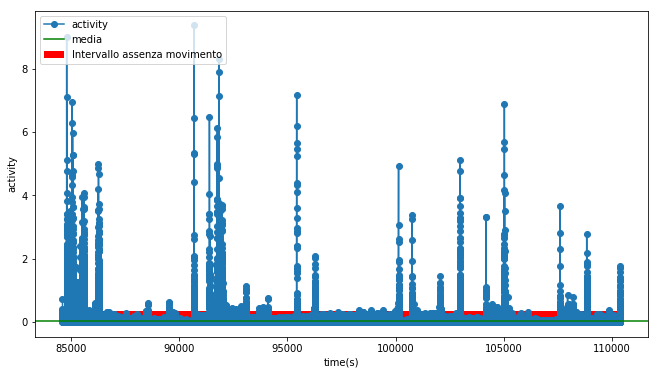

In [48]:
media=statistics.mean(activity_array)
std_dev=statistics.stdev(activity_array)
print('media: ',media)
print('std: ',std_dev)
def confidence_interval(alist, v, itv):
    return stats.t.interval(itv, df=len(alist)-1, loc=v, scale=stats.sem(alist))
CI=confidence_interval(activity_array, np.mean(activity_array), 0.1)

plt.figure(figsize=(11,6))
plt.xlabel('time(s)')
plt.ylabel('activity')
plt.plot(time_activity_array,activity_array,marker='o')
plt.axhline(y=media,color='green', linestyle='-',label='media')
plt.fill_between([time_activity_array[0],time_activity_array[len(time_activity_array)-1]],2*std_dev+media,0,facecolor='red', label='Intervallo assenza movimento')
plt.legend(loc='upper left')

Text(0,0.5,'activity')

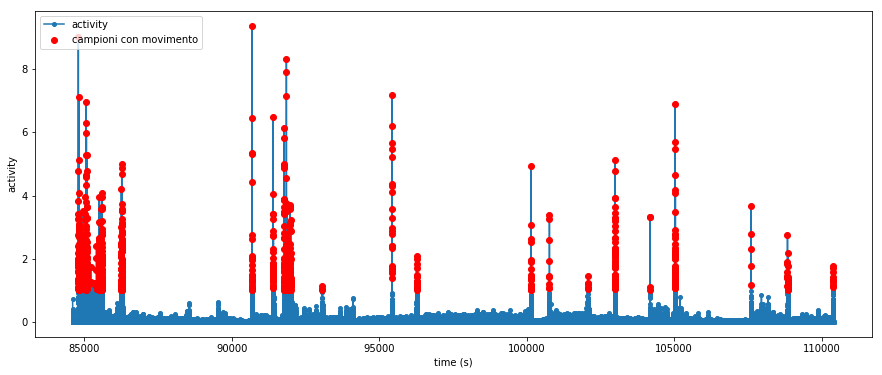

In [49]:

outlier=[]
durata=[]
valore=[]
attivita=[]
for i in range(0, len(activity_array)):
    if(activity_array[i]>1):  
        outlier.append(time_activity_array[i])
        valore.append(activity_array[i])
        attivita.append(True)
    else:
        attivita.append(False)
plt.figure(figsize=(15,6))
#for i in range(0,len(outlier)):
plt.scatter(outlier,valore,marker='o', color="red",zorder=3,label='campioni con movimento')
plt.plot(time_activity_array,activity_array,marker='o',markersize=4,zorder=2, label='activity')
plt.legend(loc='upper left')
plt.xlabel('time (s)')
plt.ylabel('activity')


#### Creo un dizionario contenente ogni campione e se è presente attività

In [50]:
#outlier = np.array(list(set(outlier)))
#key=[i for i in time_array]
#key=set(key)
#values=[]
#for i in (key):
 #   if(i in outlier):
  #      values.append(True)
   # else:
    #    values.append(False)
#diz=dict(zip(key, np.array(values).T))

#### Trasformo l'indice dell'array del tempo di spO2 in quello del tempo dell'activity

In [51]:
t=time_array[1600]
i=math.floor((t-time_activity_array[0])*ts_activity)
time_activity_array[i]


85135.30206706231

### Algoritmo per l'estrazione dei 4 punti per la desaturazione

In [52]:
desaturations=pd.DataFrame()
spo2Translaction=[]
pstart=[]
pvalley1=[]
pvalley2=[]
pstop=[]
spo2_start=[]
spo2_stop=[]
spo2_start_s=[]
spo2_stop_s=[]
spo2_valley1=[]
spo2_valley2=[]
plowest=[]
ptraslaction=[]
tdown=[]
tup=[]
tlast=[]
durata=[]
movements=[]
pv1=0
pv2=0
tup=[]
somma=0
pendenzaDiscesa=[]
pendenzaSalita=[]
'''somma=0
start_index=[]
stop_index=[]
pv1_index=[]
pv2_index=[]
stop=0'''
for i in range(0,len(spo2_array)):
    somma=somma+spo2_array[i]
xbase=1/len(spo2_array)*somma-10
CASE=0
discesa=False
minimo=100

for i in range(0,len(spo2_array)-2):
    if(CASE==0 and spo2_array[i]>spo2_array[i+1]):
        start_index=i
        minimo=100
        CASE=1
      #  minimo=spo2_array[i+1]
        discesa=True
    if(CASE==1 and spo2_array[i]==spo2_array[i+1]):
        if(discesa==True and spo2_array[i]<minimo):
            pv1=i
            minimo=spo2_array[i]
        discesa=False
    if(CASE==1 and spo2_array[i]>spo2_array[i+1]):
       # pv1=i
        pv2=i
      #  minimo=spo2_array[i+1]
        discesa=True
    if(CASE==1 and spo2_array[i]<spo2_array[i+1]):
        CASE=3
    if(CASE==3 and spo2_array[i]<spo2_array[i+1]):
        pv2=i
        #minimo=df_outlier['spO2'][i]
        CASE=4
    if(CASE==4 and spo2_array[i]==spo2_array[i+1] and spo2_array[i-1]<spo2_array[i]):
        stop_index=i
    if(CASE==4 and spo2_array[i]>spo2_array[i+1]):  
        
        start_time=df_outlier['time'][start_index]
        valley2_time=df_outlier['time'][pv2]                
        valley1_time=df_outlier['time'][pv1]
        stop_time=df_outlier['time'][stop_index]
        spo2Stop=df_outlier['spO2'][stop_index]
        spo2Start=df_outlier['spO2'][start_index]
        d=df_outlier['time'][pv2]-start_time
        p=(spo2Start-df_outlier['spO2'][pv2])/(d)
        tdown=valley2_time-start_time
        true=0
        
        
        
        #elimino desatu con attività e artifact
        start_index_activity=math.floor((start_time-time_activity_array[0])*ts_activity)
        pv2_index_activity=math.floor((valley2_time-time_activity_array[0])*ts_activity)
       # print(start_index_activity,',',pv2_index_activity)
        translactionIndex=i
        for k in range(start_index,translactionIndex):
            if(true==0 and artifact[k]==True):
                true=1
        for k in range(start_index_activity, pv2_index_activity):
            #time_activity_array[i]
            if(true==0 and attivita[k]==True):
                true=1
               # stop_index=math.floor((time_activity_array[k]-time_array[0])*ts_spO2)
                #translactionIndex=stop_index
                #pv2=stop_index
                #pv1=stop_index
        
   
        
        if(true==0 and df_outlier['spO2'][pv2]<=spo2Start*0.97 and p>0.1 and d>6):
           ## if(true==0):
            #    movements.append(False)
           # else:
            #    movements.append(True)
            #true=0
            ptraslaction.append(df_outlier['time'][translactionIndex])
            spo2Translaction.append(spo2_array[translactionIndex])
            spo2_start_s.append(datetime.timedelta(seconds=remove_days(start_time)))
            spo2_stop_s.append(datetime.timedelta(seconds=remove_days(stop_time)))          
            pstart.append(start_time)
            pstop.append(stop_time)
            spo2_start.append(spo2Start)
            spo2_stop.append(spo2Stop)
            spo2_valley1.append(df_outlier['spO2'][pv1])
            spo2_valley2.append(df_outlier['spO2'][pv2])
            pvalley1.append(valley1_time)
            pvalley2.append(valley2_time)
            durata.append(d)
           
            pendenzaDiscesa.append((spo2Start-df_outlier['spO2'][pv2])/(d)*100)
            pendenzaSalita.append((spo2Stop-df_outlier['spO2'][pv2])/(d)*100)
           # start_time=remove_days(start_time)
          #  stop_time=remove_days(stop_time)
          #  valley1_time=remove_days(valley1_time)
        start_index=i
        minimo=100
        CASE=1

            
desaturations['start_time']=pstart[0:len(pstart)]
#desaturations['tup']=tup  
desaturations['valley1']=pvalley1  
desaturations['valley2']=pvalley2  
desaturations['stop_time']=pstop
desaturations['translaction']=ptraslaction 
desaturations['start_time_s']=spo2_start_s[0:len(pstart)]
desaturations['stop_time_s']=spo2_stop_s
desaturations['valley1_spO2']=spo2_valley1  
desaturations['valley2_spO2']=spo2_valley2  
desaturations['start_spO2']=spo2_start[0:len(pstart)]
desaturations['stop_spO2']=spo2_stop  
desaturations['spo2Translaction']=spo2Translaction  

desaturations['durata (s)']=durata   
desaturations['pendenzaDiscesa']=pendenzaDiscesa 
desaturations['pendenzaSalita']=pendenzaSalita 
#desaturations['movements']=movements 
#desaturations

In [53]:
#a=desaturations.loc[desaturations['attivita'] == False]
#a=desaturations.loc[desaturations['start_time'] > 86820]
a=desaturations
#a=desaturations.loc[desaturations['movements'] == False]
a

,start_time,valley1,valley2,stop_time,translaction,start_time_s,stop_time_s,valley1_spO2,valley2_spO2,start_spO2,stop_spO2,spo2Translaction,durata (s),pendenzaDiscesa,pendenzaSalita
0,85597.346193,85610.013023,85619.346477,85619.679815,85631.346632,23:46:37.346193,23:46:59.679815,94,94,97,95,95,22.000284,13.636187,4.545396
1,85967.684311,85988.684582,85996.351348,85996.684686,86001.018075,23:52:47.684311,23:53:16.684686,93,93,97,94,94,28.667037,13.953308,3.488327
2,86152.353364,86170.686934,86174.020310,86189.687179,86203.687360,23:55:52.353364,23:56:29.687179,92,92,95,94,94,21.666947,13.845975,9.230650
3,86443.690461,86458.690655,86462.024031,86473.024173,86481.357614,00:00:43.690461,00:01:13.024173,90,90,94,93,93,18.333570,21.817900,16.363425
4,86481.357614,86488.691043,86493.357769,86500.691198,86518.691430,00:01:21.357614,00:01:40.691198,90,90,93,92,92,12.000155,24.999677,16.666451
5,86683.693562,86696.027055,86709.027223,86725.027429,86732.027520,00:04:43.693562,00:05:25.027429,92,92,95,94,94,25.333661,11.841952,7.894635
6,86800.695074,86811.695216,86812.695229,86813.028566,86861.029186,00:06:40.695074,00:06:53.028566,92,92,95,93,93,12.000155,24.999677,8.333226
7,90245.406246,90263.739816,90274.073283,90284.073412,90309.073735,01:04:05.406246,01:04:44.073412,91,91,94,94,94,28.667037,10.464981,10.464981
8,90309.073735,90325.073942,90349.074252,90359.074381,90370.741198,01:05:09.073735,01:05:59.074381,89,89,94,93,93,40.000517,12.499839,9.999871
9,90652.744842,90666.745023,90681.411879,90712.078942,90743.412680,01:10:52.744842,01:11:52.078942,91,91,94,96,96,28.667037,10.464981,17.441635


### Grafico con le desaturazioni

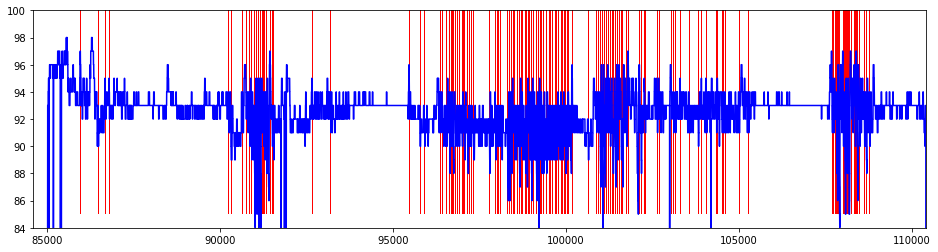

In [54]:
plt.figure(figsize=(16,4))
#plt.subplot(2, 1, 1)
plt.axis([time_array[0],time_array[len(time_array)-1],84,100])
for i in (a.index):
    plt.fill_between([a['start_time'][i],a['valley2'][i]],85,100,facecolor='red', zorder=1)
plt.plot(time_array,spo2_array,color='blue',zorder=2)


### Grafici di spO2 prima e dopo l'eliminazione dei gradini verso l'alto

0 days 01:14:54.081293 , 95


Text(0.5,0,'time (s)')

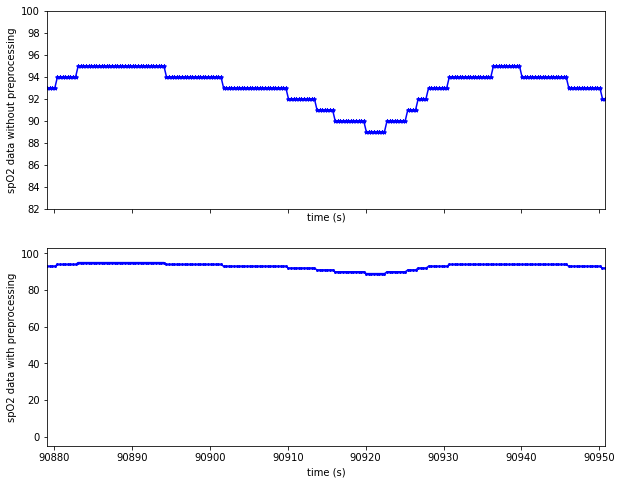

In [55]:
i=13
print(a['start_time_s'][i],',',a['start_spO2'][i])
f, axarr = plt.subplots(2, sharex=True,figsize=(10,8))
time_array=df_outlier['time']
spo2_array=df_outlier['spO2']
axarr[0].axis([pstart[i]-15,ptraslaction[i]+5,82,100])
axarr[0].plot(time_array,spo2_array, marker='*',markersize=4, color="blue")
axarr[0].set_ylabel('spO2 data without preprocessing')
axarr[0].set_xlabel('time (s)')
#ax2.fill_between([a['start_time'][i],a['stop_time'][i]],85,100,facecolor='red', zorder=1)
axarr[1].plot(time_array,spo2_array_adj, marker='o',markersize=2, color="blue")
axarr[1].set_ylabel('spO2 data with preprocessing')
axarr[1].set_xlabel('time (s)')

In [56]:
t

85135.34022403389

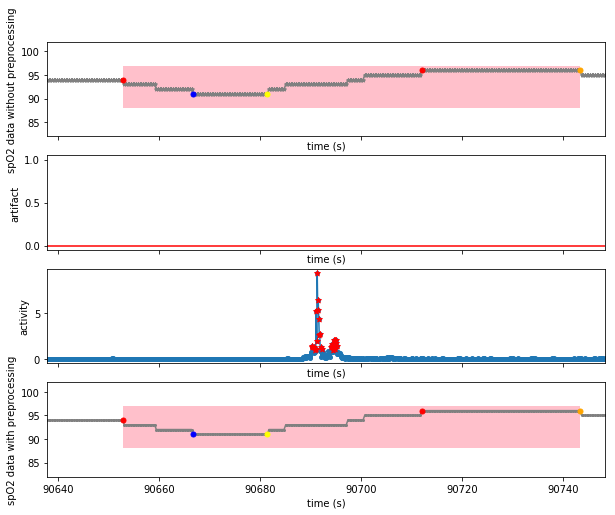

In [57]:
i=9
#print(a['start_time_s'][i],',',a['start_spO2'][i])
f, axarr = plt.subplots(4, sharex=True,figsize=(10,8))
time_array=df_outlier['time']
spo2_array=df_outlier['spO2']
axarr[0].axis([pstart[i]-15,ptraslaction[i]+10,82,102])
axarr[0].set_ylabel('spO2 data without preprocessing')
axarr[0].set_xlabel('time (s)')
axarr[0].plot(time_array,spo2_array, marker='*',markersize=4, color="gray")
#for i in range(0,len(desaturations)):
axarr[0].plot(pstart[i],spo2_start[i],  marker='o', markersize=5, color="red")
axarr[0].plot(pvalley2[i],spo2_valley2[i],  marker='o', markersize=5, color="yellow")
axarr[0].plot(pvalley1[i],spo2_valley1[i],  marker='o', markersize=5, color="blue")
axarr[0].plot(pstop[i],spo2_stop[i],  marker='o', markersize=5, color="red")
axarr[0].plot(ptraslaction[i],spo2Translaction[i],  marker='o', markersize=5, color="orange")
axarr[0].fill_between([pstart[i],ptraslaction[i]],spo2_start[i]+3,spo2_valley2[i]-3,facecolor='pink')

#ax2.fill_between([a['start_time'][i],a['stop_time'][i]],85,100,facecolor='red', zorder=1)
#axarr[1].plot(outlier[i],valore[i],marker='o',markersize=3, color="red",zorder=3)
axarr[1].plot(time_array,artifact,color='r')
axarr[1].set_ylabel('artifact')
axarr[1].set_xlabel('time (s)')

axarr[2].set_ylabel('activity')
axarr[2].set_xlabel('time (s)')
axarr[2].scatter(outlier,valore,marker='*', color="red",zorder=3,label='campioni con movimento')
axarr[2].plot(time_activity_array,activity_array,marker='o',markersize=4,zorder=2, label='activity')

axarr[3].axis([pstart[i]-15,ptraslaction[i]+5,82,102])
axarr[3].plot(time_array,spo2_array_adj, marker='o',markersize=2, color="gray")
axarr[3].set_ylabel('spO2 data with preprocessing')
axarr[3].set_xlabel('time (s)')
if i in a.index:
    axarr[3].plot(a['start_time'][i],a['start_spO2'][i],marker='o', markersize=5, color="red")
    axarr[3].plot(a['stop_time'][i],a['stop_spO2'][i],marker='o', markersize=5, color="red")
    axarr[3].plot(a['valley1'][i],a['valley1_spO2'][i],  marker='o', markersize=5, color="blue")
    axarr[3].plot(a['valley2'][i],a['valley2_spO2'][i],  marker='o', markersize=5, color="yellow")
    axarr[3].plot(a['translaction'][i],a['spo2Translaction'][i],  marker='o', markersize=5, color="orange")
    axarr[3].fill_between([a['start_time'][i],a['translaction'][i]],spo2_start[i]+3,spo2_valley2[i]-3,facecolor='pink')

#### Trasformo i tempi di inizio in hh:mm:ss in secondi in modo da confrontarli con le desaturazioni calcolate

In [58]:
inizio_s=[]
pend=[]
for i in range(0,len(desatPSD)):
    s=desatPSD['Inizio'][i]
    h,m,sec=s.split(':')
    x=int(h)*3600+int(m)*60+int(sec)
    if(int(h)<21):
        x=x+24*3600
    pend.append((desatPSD['startSpO2'][i]-desatPSD['stopSpO2'][i])/desatPSD['Durata'][i])
    inizio_s.append(x)
desatPSD['inizio_s']=inizio_s
desatPSD['pend']=pend
print(desatPSD[50:80])
#desaturations=desaturations.loc[desaturations['start_time'] > 86820]
#print(a[0:30])
print((desatPSD['pend']).min())

      Inizio  Durata  startSpO2  stopSpO2  inizio_s      pend
50  03:00:02   21.33         93        90     97202  0.140647
51  03:00:43   30.25         93        90     97243  0.099174
52  03:02:05   27.27         92        89     97325  0.110011
53  03:05:05   22.91         93        90     97505  0.130947
54  03:09:38   23.33         92        88     97778  0.171453
55  03:10:21   25.00         94        90     97821  0.160000
56  03:12:30   26.00         94        89     97950  0.192308
57  03:13:15   28.18         93        90     97995  0.106458
58  03:14:03   28.64         93        90     98043  0.104749
59  03:14:50   25.21         93        90     98090  0.119000
60  03:15:39   22.00         93        89     98139  0.181818
61  03:18:31   23.33         92        86     98311  0.257180
62  03:19:20   28.00         94        87     98360  0.250000
63  03:20:12   25.67         94        88     98412  0.233736
64  03:21:03   24.67         95        91     98463  0.162140
65  03:2

#### Elimino le desaturazioni trovate che non hanno un corrispondente verificato dal polisonnigrafo in modo da calcolare la precisione delle altre

In [59]:
a=desaturations
array_index=a.index
array_start_desat=np.array(a['start_time'])
k=0
j=0
l=len(desatPSD)
falsiPositivi=0
falsiNegativi=0
while(j<l):
    if(desatPSD['inizio_s'][j]>array_start_desat[k]+30):
        print('ELIMI:',desatPSD['Inizio'][j],',',a['start_time_s'][array_index[k]])
        a=a.drop([array_index[k]], axis='rows')
        array_start_desat=np.array(a['start_time'])    
        array_index=a.index
        falsiPositivi+=1
    if(desatPSD['inizio_s'][j]<array_start_desat[k]-30):
        print('ELIMI PSD:',desatPSD['Inizio'][j],',',a['start_time_s'][array_index[k]])
        desatPSD=desatPSD.drop(j, axis='rows')
        j=j+1
        falsiNegativi+=1
    elif(desatPSD['inizio_s'][j]>=array_start_desat[k]-30 and desatPSD['inizio_s'][j]<=array_start_desat[k]+30):
       # print('OK:',desatPSD['Inizio'][j],',',a['start_time_s'][array_index[k]])
        k=k+1
        j=j+1

#a[0:len(desatPSD)]
while(len(a)>len(desatPSD)):
    a=a.drop([array_index[k]], axis='rows')
    k=k+1
    falsiPositivi+=1
  #  print('ELIMI:',a['start_time_s'][array_index[k]])
print('f positivi: ',falsiPositivi,', f negativi: ',falsiNegativi)

ELIMI PSD: 23:59:36 , 0 days 00:00:43.690461
ELIMI: 04:16:37 , 0 days 04:15:27.221256
ELIMI PSD: 04:20:25 , 0 days 04:22:04.226385
ELIMI: 05:54:35 , 0 days 05:14:31.600382
ELIMI: 05:56:04 , 0 days 05:55:19.632011
ELIMI: 05:57:52 , 0 days 05:57:20.633574
ELIMI: 06:08:40 , 0 days 06:07:39.308234
f positivi:  5 , f negativi:  2


In [60]:
len(a)

164

#### Plot del'inizio valore spO2 ad inizio delle desaturazioni

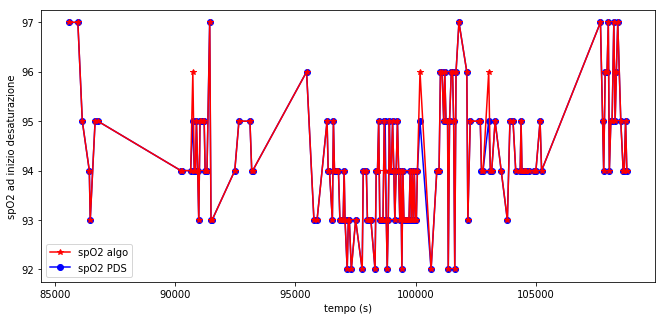

In [61]:
plt.figure(figsize=(11,5))
plt.plot(a['start_time'][0:len(desatPSD)],a['start_spO2'][0:len(desatPSD)],marker='*', color='red',zorder=2, label='spO2 algo')
plt.plot(desatPSD['inizio_s'],desatPSD['startSpO2'],marker='o',color='blue',zorder=1,label='spO2 PDS')
plt.ylabel('spO2 ad inizio desaturazione')
plt.xlabel('tempo (s)')
plt.legend(loc='best')

### Calcolo precisione algoritmo per il calcolo delle desaturazioni

##### Plot delle durate delle desat per ogni desat

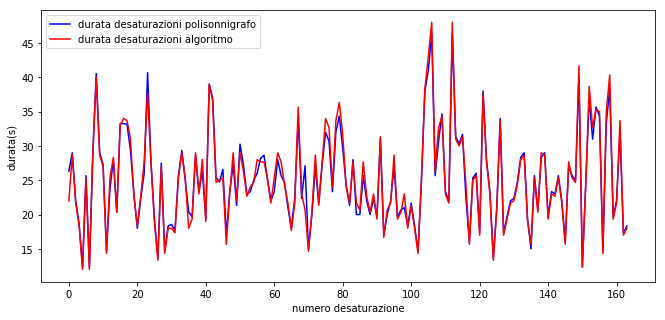

In [62]:
plt.figure(figsize=(11,5))
plt.plot([i for i in range (0,len(desatPSD))],desatPSD['Durata'],color='blue', label='durata desaturazioni polisonnigrafo')
plt.plot([i for i in range (0,len(desatPSD))],a['durata (s)'][0:len(desatPSD)],color='red', label='durata desaturazioni algoritmo')
plt.ylabel('durata(s)')
plt.xlabel('numero desaturazione')
plt.legend(loc='best')

In [63]:
desatPSD_index=desatPSD.index


##### Plot differenza tempo inizio delle desaturaz con quella precedente t(i+1)-t(i)

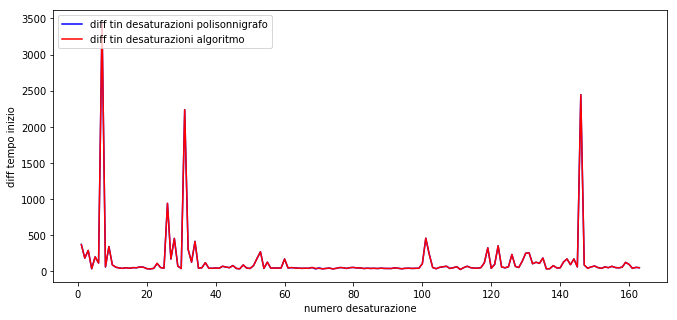

In [64]:
plt.figure(figsize=(11,5))
#plt.axis([0,3,50,60])
diff_tin_PDS=[]
diff_tin_algo=[]
for i in range(1,len(desatPSD_index)):
    diff_tin_PDS.append(desatPSD['inizio_s'][desatPSD_index[i]]-desatPSD['inizio_s'][desatPSD_index[i-1]])
    diff_tin_algo.append(a['start_time'][array_index[i]]-a['start_time'][array_index[i-1]])
plt.plot([i for i in range (1,len(desatPSD))],diff_tin_PDS,color='blue', label='diff tin desaturazioni polisonnigrafo')
plt.plot([i for i in range (1,len(desatPSD))],diff_tin_algo,color='red', label='diff tin desaturazioni algoritmo')
plt.ylabel('diff tempo inizio')
plt.xlabel('numero desaturazione')
plt.legend(loc='upper left')

##### Calcolo MSE per il tempo di inizio stimato e la durata

In [65]:
n=len(desatPSD)
#MSE tempo inizio
diff_tin=[]
for i in range(0,len(desatPSD_index)):
    diff_tin.append((a['start_time'][array_index[i]]-desatPSD['inizio_s'][desatPSD_index[i]])**2)
MSE_tempoInizio=1/n*sum(diff_tin)
print('MSE tempo di inizio delle desaturaz: ',MSE_tempoInizio, 's')

MSE tempo di inizio delle desaturaz:  1.7760984003789082 s


In [66]:
#MSE durata
diff_durata=[]
for i in range(0,len(desatPSD_index)):
    diff_durata.append((a['durata (s)'][array_index[i]]-desatPSD['Durata'][desatPSD_index[i]])**2)
MSE_durata=1/n*sum(diff_durata)
print('MSE durata delle desaturaz: ',MSE_durata, 's')

MSE durata delle desaturaz:  1.2309303158974645 s


In [67]:
for i in range (0,len(desatPSD_index)):
    print(i,',',a['start_time_s'][array_index[i]],',',desatPSD['Inizio'][desatPSD_index[i]],',',diff_tin[i])


0 , 0 days 23:46:37.346193 , 23:46:33 , 18.889394491123408
1 , 0 days 23:52:47.684311 , 23:52:47 , 0.4682817730052333
2 , 0 days 23:55:52.353364 , 23:55:52 , 0.12486593175666276
3 , 0 days 00:00:43.690461 , 00:00:43 , 0.4767365542336912
4 , 0 days 00:01:21.357614 , 00:01:21 , 0.12788808734225127
5 , 0 days 00:04:43.693562 , 00:04:43 , 0.4810281539424707
6 , 0 days 00:06:40.695074 , 00:06:40 , 0.483127281338529
7 , 0 days 01:04:05.406246 , 01:04:05 , 0.1650354539612527
8 , 0 days 01:05:09.073735 , 01:05:07 , 4.300376032304837
9 , 0 days 01:10:52.744842 , 01:10:52 , 0.5547891053353017
10 , 0 days 01:12:23.412680 , 01:12:23 , 0.17030457637782237
11 , 0 days 01:13:22.746780 , 01:13:22 , 0.5576798817959856
12 , 0 days 01:14:10.747400 , 01:14:10 , 0.5586065166475526
13 , 0 days 01:14:54.081293 , 01:14:53 , 1.1691946383499643
14 , 0 days 01:15:45.748627 , 01:15:45 , 0.5604427492608351
15 , 0 days 01:16:29.749196 , 01:16:29 , 0.5612942358442902
16 , 0 days 01:17:22.416543 , 01:17:22 , 0.173507

In [68]:
for i in range (0,len(desatPSD_index)):
    print(i,',',a['start_time_s'][array_index[i]],',',desatPSD['Inizio'][desatPSD_index[i]],',',diff_durata[i])

0 , 0 days 23:46:37.346193 , 23:46:33 , 18.746438550303775
1 , 0 days 23:52:47.684311 , 23:52:47 , 0.1108643315335407
2 , 0 days 23:55:52.353364 , 23:55:52 , 0.11092456638745915
3 , 0 days 00:00:43.690461 , 00:00:43 , 0.11318500959097294
4 , 0 days 00:01:21.357614 , 00:01:21 , 0.10879769718307562
5 , 0 days 00:04:43.693562 , 00:04:43 , 0.11312416401039345
6 , 0 days 00:06:40.695074 , 00:06:40 , 0.10879769717347587
7 , 0 days 01:04:05.406246 , 01:04:05 , 0.1108643314657072
8 , 0 days 01:05:09.073735 , 01:05:07 , 0.31302144827466355
9 , 0 days 01:10:52.744842 , 01:10:52 , 0.1108643314657072
10 , 0 days 01:12:23.412680 , 01:12:23 , 0.10866988615018368
11 , 0 days 01:13:22.746780 , 01:13:22 , 0.11321978577744786
12 , 0 days 01:14:10.747400 , 01:14:10 , 2.7677667304500724
13 , 0 days 01:14:54.081293 , 01:14:53 , 0.11135529076350158
14 , 0 days 01:15:45.748627 , 01:15:45 , 1.2931512996043284e-05
15 , 0 days 01:16:29.749196 , 01:16:29 , 0.07266994624602927
16 , 0 days 01:17:22.416543 , 01:17:

In [69]:
len(desatPSD)

164